# Tutorial 2: Conditional Adversarial Network (CGAN)
## Generating visible from infra-red satellite images

**Authors:** Paula Bigalke, Claudia Acquistapace, Daniele Corradini

**Affiliation:** Institute of Geophysics and Meteorology, University of Cologne, Germany

**Contact**: paula.bigalke@uni-koeln.de, cacquist@uni-koeln.de, dcorrad1@uni-koeln.de

## 2.3 - Training the network (x / y points)

Now that we have learned to prepare the dataset and initialize the models - we get to the most exciting step: the training of the model. In this last part of the exercise, you will train the network and implement some methods to monitor and evaluate the training. 

#### Installing packages

As always, we start by installing some packages. If you run the notebook on your personal computer, you only need to install them once. In Google Colab, however, you need to install them again each time you open the notebook.

In [ ]:
# Install packages in Google Colab
# !pip install satpy matplotlib cartopy

#In Google Colab, you use a pre-configured environment that runs in the cloud,
#but you can still install packages during your session. However, note that these installations are temporary;
#they only last for the duration of your session.
#Once the session ends, you'll need to reinstall any packages when you start a new session.

### Import Libraries

In [12]:
import time
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from keras.backend import clear_session

#### Access permission to Google Drive & setting folder path

In [4]:
##### TODO ###########################################################################################################
##### give authorization to access your Google Drive in pop-up window that opens with this code

#drivedir='/content/drive'
#drive.mount(drivedir)
#os.chdir(drivedir)

##### TODO ###########################################################################################################
##### define path to tutorial directory

TUTORIAL_DIR = "/net/merisi/pbigalke/teaching/METFUT2024/CGAN_Pix2Pix_MSG/" ### /My Drive/.../ end path with /

# check if this path exists (if you have filled in the correct loaction). 
# If it gives you "False" then there was a mistake in the path
os.path.exists(TUTORIAL_DIR)

True

### Access to our own modules and methods

In [ ]:
# add folder data_preprocessing/ and model/ to sys.path
# this enables us to read in our own modules and methods from this folder
import sys
sys.path.append(TUTORIAL_DIR + "data_processing/")
sys.path.append(TUTORIAL_DIR + "model/")

Then we need to check which devices are available in our computer. If there are GPUs (better, faster and larger) use this device, else look for CPUs.

In [2]:
# ask for GPU
devices = tf.config.experimental.list_physical_devices("GPU")
if len(devices) > 0:
    tf.config.experimental.set_memory_growth(devices[0] ,enable=True)

# if not there, ask for CPU
#else:
#    devices = tf.config.experimental.list_physical_devices("CPU")

#print(devices)

Now we load in the datasets in the same way we have done in exercise 2.1. The methods load_train_dataset and load_test_dataset are imported from the script data_processing/load_datasets.py.

In [5]:
## path to train and test datasets
TRAIN_PATH = TUTORIAL_DIR + "VIS_IR_images/train/"
TEST_PATH = TUTORIAL_DIR + "VIS_IR_images/test/"

# define image and batch size
IMAGE_SIZE = 128  # do NOT change
BATCH_SIZE = 10

# import our loading methods from data_processing/load_datasets.py
from data_processing.load_datasets import load_train_dataset, load_test_dataset

# load training and test datasets
train_dataset = load_train_dataset(TRAIN_PATH, BATCH_SIZE)
test_dataset = load_test_dataset(TEST_PATH, BATCH_SIZE)

In [6]:
# set up generator using the method provided under model.model_setup.py
from model.model_setup import generator
gen_model = generator()

# set up discriminator using the method provided under model.model_setup.py
from model.model_setup import discriminator
discr_model = discriminator()

# create optimizers for generator and discriminator
gen_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
discr_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

### (a) Monitoring the training progress (3 p)

We have already prepared a method that trains the network. Each step of the training is explained in the code. First, we loop over the epochs. For each epoch, we do 3 things: training, evaluation and saving the losses to a csv file. The training happens batch by batch and the batch losses are averaged over the epoch. So far so good!

However, we still need to monitor the progress as it could take several hours to complete the training. And we probably would like to have an overview of the status so that we can be sure the network is still happily training. And we would also like to see a sneak preview of the abilities of the generator. For this, you need to implement the following tasks:

**Task a.1** (1 p): For each epoch, write the code to plot three test images: IR image, the generated fake VIS image and the respective real VIS image. Hint: look for inspiration in data_processing/visualize_data.py

**Task a.2** (1 p): For each epoch, print the discriminator and total generator losses.

**Task a.3** (1 p): For each epoch, print the runtime for this epoch and the total runtime.

In [10]:
# import our own methods 
# defined under model/training_methods.py 
from model.training_methods import train_step  # performs one training step and returns the batch losses
from model.training_methods import eval_model  # evaluates the model on the test dataset
from model.training_methods import generate_example_images  # generates one example image triplet: ir_img, fake_vis_img, real_vis_img

# defined under data_processing.visualize_data.py
from data_processing.visualize_data import plot_images_at_epoch  # plots example images (IR, fake VIS and VIS) next to each other

# define training procedure
def fit(gen_model, discr_model, gen_optimizer, discr_optimizer, train_dataset, test_dataset, epochs, outpath_img, loss_file_out):
    """trains the model

    Parameters
    ----------
    gen_model (tf.Model): instance of the generator model
    discr_model (tf.Model): instance of the discriminator model
    gen_optimizer (tf.Optimizer): optimizer for generator
    discr_optimizer (tf.Optimizer): optimizer for discriminator
    train_dataset (tf.Data.Dataset): training dataset
    test_dataset (tf.Data.Dataset): test dataset
    epochs (int): number of epochs to train
    outpath_img (str): folder to save the plots of example images
    loss_file_out (str): csv file path for saving the losses
    """

    # get start time of training
    start_training = time.time()

    # loop over number of epochs
    for epoch in range(epochs):
        print(f"...training epoch {epoch}")

        # get start time of epoch
        start_epoch = time.time()

        # -------------------------------- Training -----------------------------------
        # train model for one epoch and calculate the average epoch losses

        # initialize epoch loss
        discr_loss = 0
        total_gen_loss = 0
        fooling_discr_loss = 0
        real_vis_similarity_loss = 0
        n_batches = len(train_dataset)

        # loop over batches in training dataset
        for n, (ir_img, real_vis_img) in train_dataset.enumerate():

            # perform training step on the batch and receive different batch losses
            discr_loss_batch, total_gen_loss_batch, fooling_discr_loss_batch, real_vis_similarity_loss_batch = \
                train_step(ir_img, real_vis_img, gen_model, discr_model, gen_optimizer, discr_optimizer)
            
            # add up batch losses
            discr_loss += discr_loss_batch
            total_gen_loss += total_gen_loss_batch
            fooling_discr_loss += fooling_discr_loss_batch
            real_vis_similarity_loss += real_vis_similarity_loss_batch

        # take average of summed batch losses to get the overall loss for this epoch
        discr_loss /= n_batches
        total_gen_loss /= n_batches
        fooling_discr_loss /= n_batches
        real_vis_similarity_loss /= n_batches

        # -------------------------------- Evaluation ---------------------------------
        # calculate test losses
        discr_loss_test, total_gen_loss_test, fooling_discr_loss_test, real_vis_similarity_loss_test = \
            eval_model(test_dataset, gen_model, discr_model)

        # -------------------------------- Saving losses ------------------------------
        # collect losses in list
        loss_list = [epoch+1, discr_loss.numpy(), discr_loss_test.numpy(), \
                     total_gen_loss.numpy(), total_gen_loss_test.numpy(), \
                     fooling_discr_loss.numpy(), fooling_discr_loss_test.numpy(), \
                     real_vis_similarity_loss.numpy(), real_vis_similarity_loss_test.numpy()]
        
        # open csv file and append losses from this epoch
        with open(loss_file_out, 'a') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(loss_list)

        # -------------------------------- Plot example images -----------------------------------

        # select a random image triplet from test dataset
        test_ir_img, test_fake_vis_img, test_real_vis_img = generate_example_images(test_dataset, gen_model)
        
        ##### TODO ###################################################################################################
        ##### plot all three test images in one plot: infra-red image, the generated fake visible image and the real visible image
        ##### Hint: look for inspiration in data_processing/visualize_data.py
        output_file = outpath_img + "test_images_example_epoch{epoch}.png"

        # plot_images_at_epoch(...)  # TODO

        # <<<<<< Solution
        plot_images_at_epoch(test_ir_img, test_fake_vis_img, test_real_vis_img, 
                             output_file=output_file, normalized=True)
        
        # -------------------------------- Print training status ----------------------------------- 

        ##### TODO ###################################################################################################
        ##### print the discriminator and total generator loss of this epoch
        
        #print("Discriminator loss: ", ..., "Generator loss: ", ...)  # TODO

        # <<<<<< Solution
        print(f"Discriminator loss: {discr_loss:.2f}, Generator loss: {total_gen_loss:.2f}")

        ##### TODO ###################################################################################################
        ##### print the time it took for this epoch and the current total runtime IN MINUTES
        #print(f"Time [min] for epoch {epoch+1}: ", ...)  # TODO
        #print("Total runtime [min]: ", ...)  # TODO

        # <<<<<< Solution
        print(f"Time for epoch {epoch+1}: {(time.time()-start_epoch)/60.:.2f} min.")
        print(f"Total runtime: {(time.time()-start_training)/60.:.2f} min.")

### (b) Training the network (4 p)

**Task b.1** (4 p): 
First, train the network for only a few epochs, e.g. 3, to check if you implemented everything correctely. 

Once you are confident that everything works as it should, start the training for 150 epochs. 

...training epoch 0


2024-05-30 23:41:14.255799: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-05-30 23:42:31.143927: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


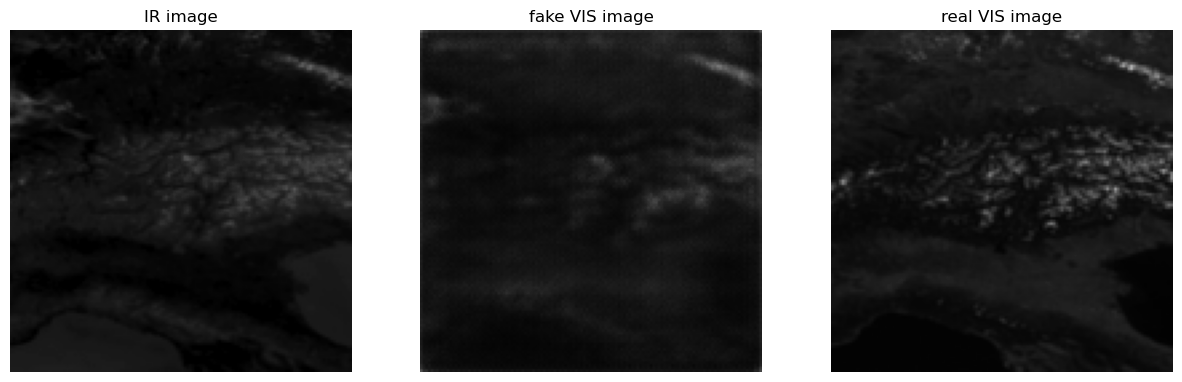

Discriminator loss: 1.16, Generator loss: 22.45
Time for epoch 1: 1.35 min.
Total runtime: 1.35 min.


In [11]:
##### TODO ###########################################################################################################
##### define number of epochs (start with a low number e.g. 3 and once all works fine you can run the whole training)
EPOCHS = 1  # 150

# path where to store example images
OUT_IMG = TUTORIAL_DIR + "output/training/example_images/"
if not os.path.exists(OUT_IMG):
    os.makedirs(OUT_IMG)

# file where to store losses
LOSS_FILE = TUTORIAL_DIR + "output/training/losses.csv"
with open(LOSS_FILE, 'w') as csv_file:
    writer = csv.writer(csv_file)
    # write header to file - giving names to the respective columns
    header = ["epoch", "discr", "discr_test", "total_gen", "total_gen_test", \
              "fooling_discr", "fooling_discr_test", "vis_similarity", "vis_similarity_test"]
    writer.writerow(header)

# clear previous training session
clear_session()

# train the model
fit(gen_model, discr_model, gen_optimizer, discr_optimizer, train_dataset, test_dataset, EPOCHS, 
    outpath_img=OUT_IMG, loss_file_out=LOSS_FILE)

### (c) Interpretation of losses (5 p)

Congratulations - you've trained a conditional adversarial network! And look at the nice VIS images the generator creates towards the end of the training - well done! Now we will investigate the development of the loss to understand and potentially optimize the training.

**Task c.1** (1 p): Plot the total generator losses using the provided method. Make sure to plot both the training and test loss.

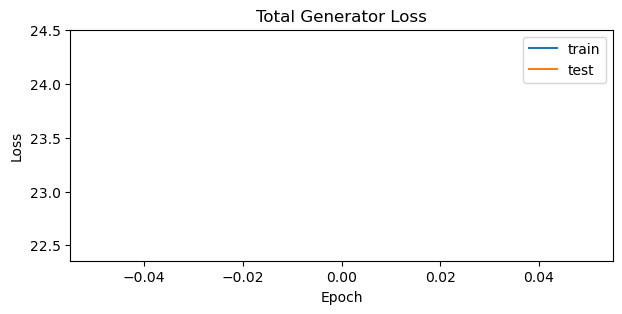

In [14]:
def plot_losses(train_loss, test_loss, title="insert the type of loss shown", output_file=None):

    plt.figure(figsize = (7,3))
    plt.title(title)

    # plot both losses with labels
    plt.plot(train_loss, label="train")
    plt.plot(test_loss, label="test")

    # name the axes
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # draw legend
    plt.legend(loc=0)

    # save image if output file is defined
    if output_file is not None:
        plt.savefig(output_file, bbox_inches="tight")
    plt.show()
    plt.close()


# read in csv file containing all the losses
losses = pd.read_csv(LOSS_FILE)

"""
this file contains all losses for each epoch that were collected during training
you can access the columns by their names:
"epoch" = epoch number
"discr" = total loss of discriminator model
"discr_test" = same but evaluated on test dataset
"total_gen" = total loss of generator model
"total_gen_test" = same but evaluated on test dataset
"fooling_discr" = part of generator loss representing how well it fooled the discriminator
"fooling_discr_test" = same but evaluated on test dataset
"vis_similarity" = part of generator loss representing how well it recreated the real VIS image
"vis_similarity_test" = same but evaluated on test dataset
"""

# define output file
total_gen_loss_outfile = TUTORIAL_DIR + "output/training/total_gen_loss.png"

##### TODO ###########################################################################################################
##### plot the total generator loss of the training and test dataset

# plot_losses(...)  # TODO

# <<<<<< Solution
plot_losses(losses.total_gen, losses.total_gen_test, 
            title="Total Generator Loss", 
            output_file=total_gen_loss_outfile)

**Question c.2** (1 p): Why is the test loss always higher (= worse) than the training loss? And is that a problem?

Answer: ...  # TODO

*Solution: The test images were never seen by the network during training, whereas the network saw the training images many times. That is why it naturally performs better on the training dataset.*

**Question c.3** (1 p): At which epoch could you have stopped the training without significantly lowering the generator's performance? Why?

Answer: ...  # TODO

*Solution: Where the test loss does not significantly improve anymore.. or other answers are also fine.*

**Question c.4** (1 p): Do you see any overfitting in your training? Why / Why not?

Answer: ...  # TODO

*Solution: No, probably not. Overfitting can be seen when the test acccuracy gets worse again. But maybe it is overfitting when the test loss reaches plateau but the train loss continues to decrease... Discuss with group before correcting exercises.*

**Question c.5** (1 p): How could you evaluate the visual quality of the generated images? Check the paper on "Image-to-Image Translation with Conditional Adversarial Networks" for some ideas (https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf).

Answer: ...  # TODO
